Loading images from: /content/drive/MyDrive/Brain-Tumor-Classification-DataSet/Training/glioma_tumor
Loading images from: /content/drive/MyDrive/Brain-Tumor-Classification-DataSet/Training/meningioma_tumor
Loading images from: /content/drive/MyDrive/Brain-Tumor-Classification-DataSet/Training/no_tumor
Loading images from: /content/drive/MyDrive/Brain-Tumor-Classification-DataSet/Training/pituitary_tumor
Loading images from: /content/drive/MyDrive/Brain-Tumor-Classification-DataSet/Testing/glioma_tumor
Loading images from: /content/drive/MyDrive/Brain-Tumor-Classification-DataSet/Testing/meningioma_tumor
Loading images from: /content/drive/MyDrive/Brain-Tumor-Classification-DataSet/Testing/no_tumor
Loading images from: /content/drive/MyDrive/Brain-Tumor-Classification-DataSet/Testing/pituitary_tumor
Total images loaded: 3264
58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/50
 6/92 [>.............................] - ETA: 17s - loss: 16.1980 - accuracy: 0.2188

92/92 [==============================] - ETA: 0s - loss: 12.6628 - accuracy: 0.2669
Epoch 1: val_accuracy improved from -inf to 0.26911, saving model to braintumor_best.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


92/92 [==============================] - 54s 368ms/step - loss: 12.6628 - accuracy: 0.2669 - val_loss: 9.6566 - val_accuracy: 0.2691
Epoch 2/50
92/92 [==============================] - ETA: 0s - loss: 7.8539 - accuracy: 0.3023
Epoch 2: val_accuracy improved from 0.26911 to 0.29969, saving model to braintumor_best.h5
92/92 [==============================] - 24s 254ms/step - loss: 7.8539 - accuracy: 0.3023 - val_loss: 6.4037 - val_accuracy: 0.2997
Epoch 3/50
92/92 [==============================] - ETA: 0s - loss: 5.4961 - accuracy: 0.3194
Epoch 3: val_accuracy improved from 0.29969 to 0.35780, saving model to braintumor_best.h5
92/92 [==============================] - 25s 268ms/step - loss: 5.4961 - accuracy: 0.3194 - val_loss: 4.7335 - val_accuracy: 0.3578
Epoch 4/50
92/92 [==============================] - ETA: 0s - loss: 4.1788 - accuracy: 0.4154
Epoch 4: val_accuracy improved from 0.35780 to 0.56575, saving model to braintumor_best.h5
92/92 [==============================] - 25s 269

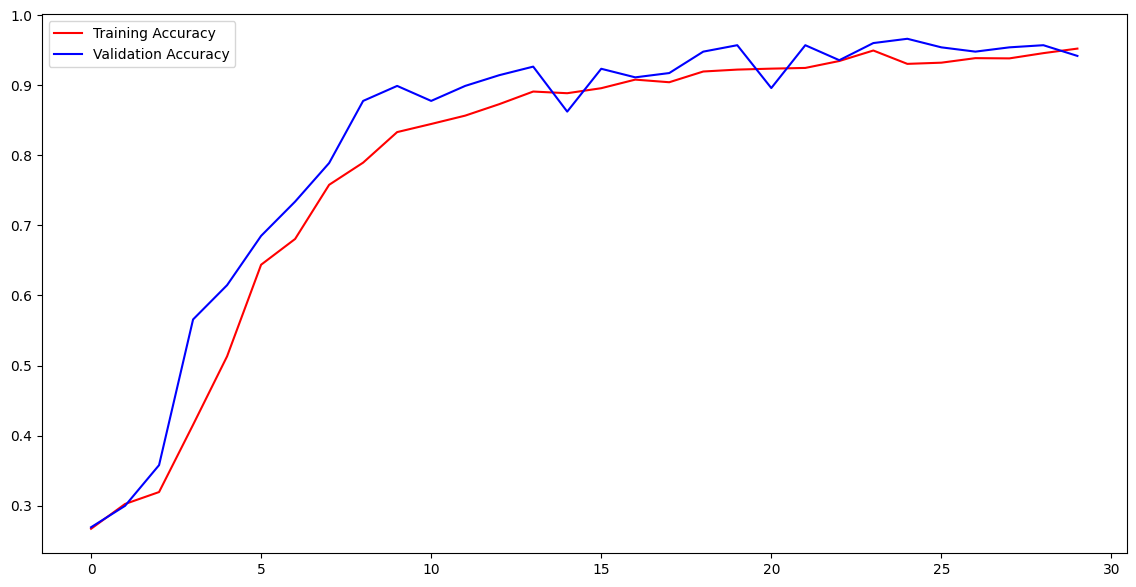

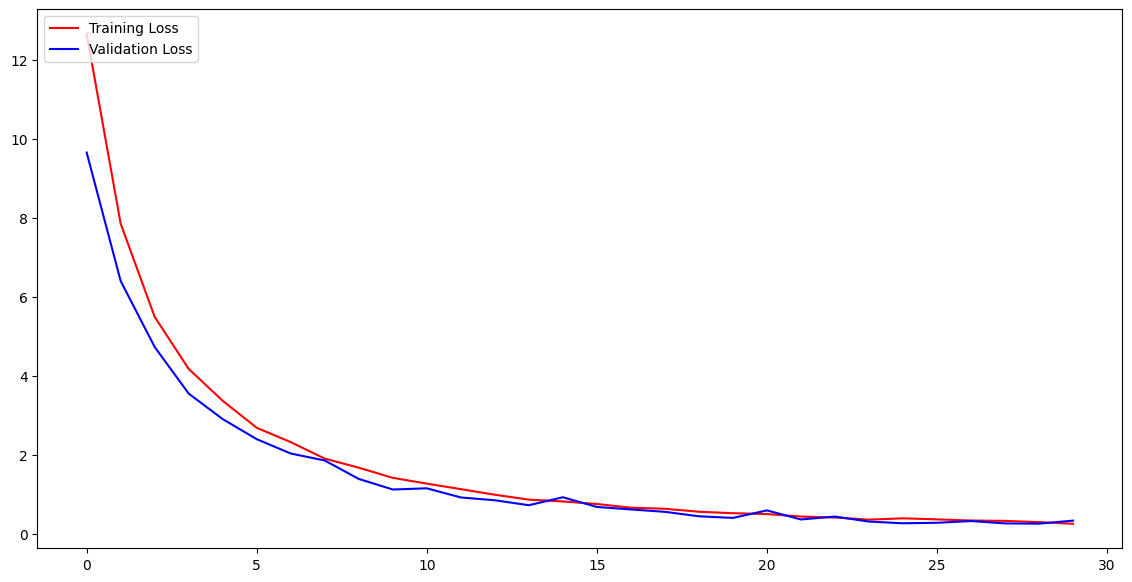

In [ ]:
import numpy as np
import os
import cv2
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback

# Function to preprocess images
def preprocess_images(image_size=150):
    X = []
    Y = []
    labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

    training_path = r'/content/drive/MyDrive/Brain-Tumor-Classification-DataSet/Training'
    testing_path = r'/content/drive/MyDrive/Brain-Tumor-Classification-DataSet/Testing'

    for label in labels:
        folderPath = os.path.join(training_path, label)
        if not os.path.exists(folderPath):
            print(f"Training path not found: {folderPath}")
            continue
        print(f"Loading images from: {folderPath}")
        for img_name in os.listdir(folderPath):
            img_path = os.path.join(folderPath, img_name)
            img = cv2.imread(img_path)
            if img is None:
                print(f"Image not loaded: {img_path}")
                continue
            img = cv2.resize(img, (image_size, image_size))
            img = img / 255.0  # Normalize to [0, 1]
            X.append(img)
            Y.append(label)

    for label in labels:
        folderPath = os.path.join(testing_path, label)
        if not os.path.exists(folderPath):
            print(f"Testing path not found: {folderPath}")
            continue
        print(f"Loading images from: {folderPath}")
        for img_name in os.listdir(folderPath):
            img_path = os.path.join(folderPath, img_name)
            img = cv2.imread(img_path)
            if img is None:
                print(f"Image not loaded: {img_path}")
                continue
            img = cv2.resize(img, (image_size, image_size))
            img = img / 255.0  # Normalize to [0, 1]
            X.append(img)
            Y.append(label)

    X = np.array(X)
    Y = np.array(Y)
    print(f"Total images loaded: {len(X)}")
    return X, Y, labels

# Function for data augmentation
def augment_data(X, y, labels):
    datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    y_new = [labels.index(label) for label in y]
    y_new = tf.keras.utils.to_categorical(y_new)

    return datagen, X, y_new

# Function to build and compile the VGG16 model
def build_vgg16_model(input_shape, num_classes):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = Flatten()(x)
    x = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # Unfreeze some layers of the base model
    for layer in base_model.layers:
        layer.trainable = True

    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['accuracy'])
    return model

# Custom callback to stop training when accuracy reaches 94%
class StopAt94Accuracy(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_accuracy') >= 0.97:
            print(f"\nReached 97% validation accuracy so stopping training at epoch {epoch+1}.")
            self.model.stop_training = True

# Main function to run the training process
def main():
    X, Y, labels = preprocess_images()
    X, Y = shuffle(X, Y, random_state=101)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=101)

    datagen, X_train, y_train = augment_data(X_train, y_train, labels)
    _, X_test, y_test = augment_data(X_test, y_test, labels)  # Data augmentation is not typically applied to test data

    model = build_vgg16_model((150, 150, 3), len(labels))

    # Model checkpointing and early stopping
    checkpoint = ModelCheckpoint('braintumor_best.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', verbose=1)
    stop_at_94 = StopAt94Accuracy()

    history = model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=50, validation_data=(X_test, y_test), callbacks=[checkpoint, early_stopping, stop_at_94])

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(len(acc))
    plt.figure(figsize=(14, 7))
    plt.plot(epochs, acc, 'r', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    plt.legend(loc='upper left')
    plt.show()

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.figure(figsize=(14, 7))
    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.legend(loc='upper left')
    plt.show()

    model.save('braintumor_final.h5')

if __name__ == "__main__":
    main()

1/1 [==============================] - 0s 142ms/step


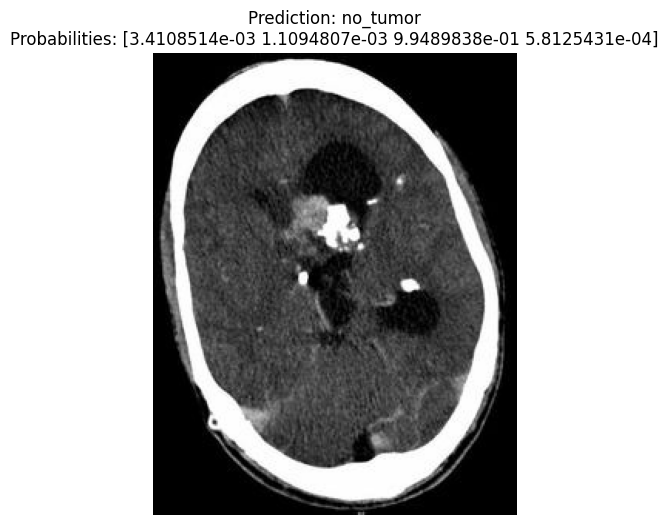

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('/content/braintumor_best.h5')

# Define label mapping
labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

def preprocess_image(image_path, target_size=(150, 150)):
    # Read the image file
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Image not loaded: {image_path}")

    # Resize and normalize the image
    image = cv2.resize(image, target_size)
    image = image / 255.0  # Normalize to [0, 1]
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

def predict_image(image_path):
    # Preprocess the image
    processed_image = preprocess_image(image_path)

    # Predict
    predictions = model.predict(processed_image)
    predicted_class = np.argmax(predictions, axis=1)[0]
    return labels[predicted_class], predictions[0]

def display_image_with_prediction(image_path):
    # Load and display the image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Image not loaded: {image_path}")

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Make prediction
    predicted_class, prediction_proba = predict_image(image_path)

    # Plot the image and prediction
    plt.figure(figsize=(8, 6))
    plt.imshow(image_rgb)
    plt.title(f'Prediction: {predicted_class}\nProbabilities: {prediction_proba}')
    plt.axis('off')
    plt.show()

# Path to the image you want to test
image_path = '/content/image(89).jpg'

# Display the image and prediction
display_image_with_prediction(image_path)
